In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve, auc, average_precision_score
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

## Read in data

In [10]:
adam_df_2016 = pd.read_csv(f'../data/Adam_2016_Top_Songs.csv')
adam_df_2017 = pd.read_csv(f'../data/Adam_2017_Top_Songs.csv')
adam_df_2018 = pd.read_csv(f'../data/Adam_2018_Top_Songs.csv')
adam_df_2019 = pd.read_csv(f'../data/Adam_2019_Top_Songs.csv')
adam_df_2020 = pd.read_csv(f'../data/Adam_2020_Top_Songs.csv')
adam_df_2021 = pd.read_csv(f'../data/Adam_2021_Top_Songs.csv')

In [11]:
brenda_df_2016 = pd.read_csv(f'../data/Brenda_2016_Top_Songs.csv')
brenda_df_2017 = pd.read_csv(f'../data/Brenda_2017_Top_Songs.csv')
brenda_df_2018 = pd.read_csv(f'../data/Brenda_2018_Top_Songs.csv')
brenda_df_2019 = pd.read_csv(f'../data/Brenda_2019_Top_Songs.csv')
brenda_df_2020 = pd.read_csv(f'../data/Brenda_2020_Top_Songs.csv')
brenda_df_2021 = pd.read_csv(f'../data/Brenda_2021_Top_Songs.csv')

In [12]:
adam_df_concat = pd.concat([adam_df_2016, adam_df_2017, adam_df_2018, adam_df_2019, adam_df_2020, adam_df_2021], ignore_index=True, axis=0)
brenda_df_concat = pd.concat([brenda_df_2016, brenda_df_2017, brenda_df_2018, brenda_df_2019, brenda_df_2020, brenda_df_2021], ignore_index=True, axis=0)
both_df_concat = pd.concat([adam_df_concat, brenda_df_concat], ignore_index=True, axis=0)

## Prepare data for machine learning models

### Convert numeric variables to scale of [0,1]

In [13]:
# Funtion also used in "01_Data_Visualization.ipynb"
# Create function to do linear transformation on variable to change value to [0,1]
def convert_scale(df, col):
    df[col + '_old'] = df[col]
    new_max = 1
    new_min = 0
    new_range = new_max-new_min
    max_val = df[col].max()
    min_val=df[col].min()
    val_range = max_val - min_val
    df[col]=df[col].apply(lambda x: (((x-min_val)*new_range)/val_range)+new_min)
    return

In [14]:
numeric_cols = ['length',
                'popularity',
                'acousticness', 
                'danceability',
                'energy', 
                'instrumentalness',
                'liveness',
                'loudness',
                'speechiness',
                'valence',
                'tempo', 
                'release_year']

for col in numeric_cols:
    convert_scale(both_df_concat, col)

In [15]:
df_both_adj = both_df_concat.copy()
# df_both_adj

### Onehot encode categorical variables

In [16]:
oe_style = OneHotEncoder()
oe_results = oe_style.fit_transform(df_both_adj[['time_signature', 'mode', 'key']])
onehot = pd.DataFrame(oe_results.toarray(), columns=['time_signature_1', 'time_signature_2', 
                                                     'time_signature_3', 'time_signature_4', 
                                                     'mode_1', 'mode_2',
                                                     'key_1', 'key_2', 'key_3', 'key_4', 'key_5', 'key_6',
                                                     'key_7', 'key_8', 'key_9', 'key_10', 'key_11', 'key_12'])
df_both_adj = pd.concat([df_both_adj, onehot], axis=1) 
# df_both_adj.T

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [17]:
model_feature_cols = ['energy',
    'valence',
    'danceability',
    'liveness',
    'speechiness',
    'instrumentalness',
    'acousticness',
    'loudness',
    'length',
    'popularity',
    'tempo',
    'release_year',
    'time_signature_1',
    'time_signature_2',
    'time_signature_3',
    'time_signature_4',
    'mode_1', 
    'mode_2',
    'key_1',
    'key_2',
    'key_3',
    'key_4',
    'key_5',
    'key_6',
    'key_7',       
    'key_8',
    'key_9',
    'key_10',
    'key_11',
    'key_12']

model_y_cols = ['name', 
                'album', 
                'artist']

In [18]:
df_both_adj = df_both_adj[model_feature_cols + model_y_cols]
df_both_adj['true_label'] = ['0'] * 600 + ['1'] * 600

adam_df_concat = df_both_adj.iloc[:600]
brenda_df_concat  = df_both_adj.iloc[600:].reset_index()

### Remove repeated songs

In [19]:
# remove repeats on individual playlists
def remove_repeats(df):
    rows_old = range(len(df['name']))
    rows_new = []
    skips = []
    for i in range(len(df['name'])):
        for j in range(i+1, len(df['name'])):
            if (df['name'][i] == df['name'][j]) and (df['artist'][i] == df['artist'][j]):
                skips.append(j)
    for row in rows_old:
        if not row in skips:
            rows_new.append(row)
    df = df.iloc[rows_new,:].reset_index(drop=True)
    return df

In [20]:
df_adam_no_repaeats = remove_repeats(adam_df_concat)
df_brenda_no_repeats = remove_repeats(brenda_df_concat)

print(len(df_adam_no_repaeats), len(df_brenda_no_repeats))

456 519


### Remove songs if they have both categories

In [21]:
# remove songs on both playlists (12)
def remove_same_songs(df1, df2):
    rows_old_df1 = range(len(df1['name']))
    rows_new_df1 = []
    rows_old_df2 = range(len(df2['name']))
    rows_new_df2 = []
    same_songs_df1 = []
    same_songs_df2 = []
    for i in range(len(df1['name'])):
        for j in range(len(df2['name'])):
            if (df1['name'][i] == df2['name'][j]) and (df1['artist'][i] == df2['artist'][j]):
                same_songs_df1.append(i)
                same_songs_df2.append(j)
    for row in rows_old_df1:
        if not row in same_songs_df1:
            rows_new_df1.append(row)
    for row in rows_old_df2:
        if not row in same_songs_df2:
            rows_new_df2.append(row)
    df1 = df1.iloc[rows_new_df1,:].reset_index(drop=True)
    df2 = df2.iloc[rows_new_df2,:].reset_index(drop=True)
    return df1, df2
    
df_adam_no_repeats_no_same, df_brenda_no_repeats_no_same = remove_same_songs(df_adam_no_repaeats,
                                                                               df_brenda_no_repeats)
print(len(df_adam_no_repeats_no_same))
print(len(df_brenda_no_repeats_no_same))
# print(df_adam_no_repaeats_no_same)

444
507


### Upsample smaller category so number of samples per class size is equal

In [22]:
# upsample adam for same size categories
def add_missing_songs(df, n, state):
    r = np.random.RandomState(seed=state)
    new_samples = r.choice(df.shape[0], size=n, replace=False)
    new_df = pd.concat([df,  df.iloc[new_samples,:]], ignore_index=True, axis=0)
    return new_df

In [23]:
df_adam_no_repeats_no_same_up_sampled = add_missing_songs(df_adam_no_repeats_no_same, 63, 42)
# df_adam_no_repeats_no_same_up_sampled

In [24]:
def limit_features(df):
    return df[model_feature_cols]

In [25]:
adam_features = limit_features(df_adam_no_repeats_no_same_up_sampled)
brenda_features = limit_features(df_brenda_no_repeats_no_same)

### Get training and test sets

In [26]:
def get_train_test(df, n, state):
    r = np.random.RandomState(seed=state)
    new_samples = list(r.choice(df.shape[0], size=n, replace=False))
    
    train_1 = new_samples[0:400] + new_samples[500:508]
    test_1 = new_samples[400:500]
    
    train_2 = new_samples[0:300] + new_samples[400:500] + new_samples[500:508]
    test_2 = new_samples[300:400]
    
    train_3 = new_samples[0:200] + new_samples[300:500] + new_samples[500:508]
    test_3 = new_samples[200:300]
    
    train_4 = new_samples[0:100] + new_samples[200:500] + new_samples[500:508]
    test_4 = new_samples[100:200]
    
    train_5 = new_samples[200:500] + new_samples[500:508]
    test_5 = new_samples[0:100]
    
#     print(new_samples)
    
    return train_1, test_1, train_2, test_2, train_3, test_3, train_4, test_4, train_5, test_5

In [27]:
train_test = get_train_test(df_adam_no_repeats_no_same_up_sampled,
                            df_adam_no_repeats_no_same_up_sampled.shape[0],
                            42)

train_1, test_1, train_2, test_2, train_3, test_3, train_4, test_4, train_5, test_5 =\
train_test[0], train_test[1], train_test[2], train_test[3], train_test[4], train_test[5], train_test[6], train_test[7], train_test[8], train_test[9]

In [28]:
adam_train_1 = adam_features.iloc[train_1,:]
adam_train_2 = adam_features.iloc[train_2,:]
adam_train_3 = adam_features.iloc[train_3,:]
adam_train_4 = adam_features.iloc[train_4,:]
adam_train_5 = adam_features.iloc[train_5,:]

brenda_train_1 = brenda_features.iloc[train_1,:]
brenda_train_2 = brenda_features.iloc[train_2,:]
brenda_train_3 = brenda_features.iloc[train_3,:]
brenda_train_4 = brenda_features.iloc[train_4,:]
brenda_train_5 = brenda_features.iloc[train_5,:]

adam_test_1 = adam_features.iloc[test_1,:]
adam_test_2 = adam_features.iloc[test_2,:]
adam_test_3 = adam_features.iloc[test_3,:]
adam_test_4 = adam_features.iloc[test_4,:]
adam_test_5 = adam_features.iloc[test_5,:]

brenda_test_1 = brenda_features.iloc[test_1,:]
brenda_test_2 = brenda_features.iloc[test_2,:]
brenda_test_3 = brenda_features.iloc[test_3,:]
brenda_test_4 = brenda_features.iloc[test_4,:]
brenda_test_5 = brenda_features.iloc[test_5,:]

In [29]:
def get_train_and_test(adam_train, brenda_train, adam_test, brenda_test):
    train_X = pd.concat([adam_train, brenda_train])
    test_X = pd.concat([adam_test, brenda_test])
    train_y = ([0]*len(adam_train)) + ([1]*len(brenda_train))
    test_y = ([0]*len(adam_test)) + ([1]*len(brenda_test))
    return train_X, test_X, train_y, test_y

In [30]:
train_X_1, test_X_1, train_y_1, test_y_1 = get_train_and_test(adam_train_1, 
                                                              brenda_train_1, 
                                                              adam_test_1,
                                                              brenda_test_1)
train_X_2, test_X_2, train_y_2, test_y_2 = get_train_and_test(adam_train_2,
                                                              brenda_train_2,
                                                              adam_test_2, 
                                                              brenda_test_2)
train_X_3, test_X_3, train_y_3, test_y_3 = get_train_and_test(adam_train_3,
                                                              brenda_train_3, 
                                                              adam_test_3,
                                                              brenda_test_3)
train_X_4, test_X_4, train_y_4, test_y_4 = get_train_and_test(adam_train_4,
                                                              brenda_train_4, 
                                                              adam_test_4,
                                                              brenda_test_4)
train_X_5, test_X_5, train_y_5, test_y_5 = get_train_and_test(adam_train_5,
                                                              brenda_train_5, 
                                                              adam_test_5,
                                                              brenda_test_5)

### Evaluation functions

In [31]:
def accuracy(conf_matrix):
    tn = conf_matrix[0][0]
    tp = conf_matrix[1][1]
    fp = conf_matrix[1][0]
    fn = conf_matrix[0][1]
    return (tp + tn) / (tp + tn + fp + fn)

In [32]:
def precision(conf_matrix):
    tp = conf_matrix[1][1]
    fp = conf_matrix[1][0]
    return tp / (tp + fp)

In [33]:
def recall(conf_matrix):
    tp = conf_matrix[1][1]
    fn = conf_matrix[0][1]
    return tp / (tp + fn)

In [34]:
def specificity(conf_matrix):
    tn = conf_matrix[0][0]
    fp = conf_matrix[1][0]
    return tn / (tn + fp)

In [35]:
def f1(conf_matrix):
    tp = conf_matrix[1][1]
    fp = conf_matrix[1][0]
    fn = conf_matrix[0][1]
    precision_ = precision(conf_matrix)
    recall_ = recall(conf_matrix)
    return 2 * precision_ * recall_ / (precision_ + recall_)

In [36]:
def plot_roc(title, false_positive_rate, true_positive_rate, save=False):
    plt.subplots(1)
    plt.title(title)
    plt.plot(false_positive_rate, true_positive_rate)
    plt.plot([0, 1], ls="--")
    plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    if save != False:
        plt.savefig(save, bbox_inches='tight')
    plt.show()
    
def plot_pr_curve(y_test, y_score, save=False):
    # calculate precision and recall
    precision, recall, thresholds = precision_recall_curve(y_test, y_score)

    #create precision recall curve
    fig, ax = plt.subplots()
    ax.plot(recall, precision, color='purple')
    
    #add axis labels to plot
    ax.set_title('Precision-Recall Curve')
    ax.set_ylabel('Precision')
    ax.set_xlabel('Recall')

    #display plot
    if save != False:
        plt.savefig(save, bbox_inches='tight')
    plt.show()

### Compare predictions to actual

In [37]:
def compare_predictions_Adam(preds, preds_, actual, test_set, df_X_no_repeats_no_same_up_sampled):
    test_set = test_set.copy()
    test_set.loc[:,'prediction'] = preds[:100]
    test_set.loc[:,'prediction_probability'] = preds_[:100]
    test_set['actual'] = actual[:100]
    test_set.loc[:,'name'] = df_X_no_repeats_no_same_up_sampled.loc[test_set.index,'name']
    test_set.loc[:,'artist'] = df_X_no_repeats_no_same_up_sampled.loc[test_set.index,'artist']
    test_set.loc[:,'album'] = df_X_no_repeats_no_same_up_sampled.loc[test_set.index,'album']
    test_set = test_set.reset_index()
    test_set = test_set.rename(columns={'index': 'original_index'})
    test_set = test_set.sort_values('prediction_probability', ascending=False).reset_index()   
    return test_set


def compare_predictions_Brenda(preds, preds_, actual, test_set, df_X_no_repeats_no_same):
    test_set = test_set.copy()
    test_set.loc[:,'prediction'] = preds[100:]
    test_set.loc[:,'prediction_probability'] = preds_[100:]
    test_set['actual'] = actual[100:]
    test_set.loc[:,'name'] = df_X_no_repeats_no_same.loc[test_set.index,'name']
    test_set.loc[:,'artist'] = df_X_no_repeats_no_same.loc[test_set.index,'artist']
    test_set.loc[:,'album'] = df_X_no_repeats_no_same.loc[test_set.index,'album']
    test_set = test_set.reset_index()
    test_set = test_set.rename(columns={'index': 'original_index'})
    test_set = test_set.sort_values('prediction_probability', ascending=True).reset_index()
    return test_set

### Logistic Regression

In [38]:
lr = LogisticRegression()

In [39]:
# define search space
space = dict()

space['solver'] = ['newton-cg', 'lbfgs', 'liblinear']
space['penalty'] = ['l2']

# define search
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=42)
search = GridSearchCV(lr, space, scoring='accuracy', cv=cv)
result = search.fit(X=train_X_1, y=train_y_1)
# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Best Score: 0.7604422604422605
Best Hyperparameters: {'penalty': 'l2', 'solver': 'liblinear'}


In [40]:
lr = LogisticRegression(penalty='l2', solver='liblinear')

In [41]:
lr.fit(X=train_X_1, y=train_y_1)
preds = lr.predict(X=test_X_1)
adam_y_test = preds[:100]
brenda_y_test = preds[100:]
actual_values = [0] * 100 + [1] * 100
predicted_values = list(preds[:100]) + list(preds[100:])
preds_ = lr.predict_proba(test_X_1)[:,1]
false_positive_rate, true_positive_rate, threshold = roc_curve(actual_values, preds_)
# in binary classification, 
# the count of true negatives is C_00,
# false negatives is C_10,
# true positives is  C_11, 
# and false positives is C_01.
conf_matrix = confusion_matrix(actual_values, predicted_values)
conf_matrix

array([[86, 14],
       [34, 66]])

In [42]:
accuracy(conf_matrix)

0.76

In [43]:
precision(conf_matrix)

0.66

In [44]:
recall(conf_matrix)

0.825

In [45]:
specificity(conf_matrix)

0.7166666666666667

In [46]:
f1(conf_matrix)

0.7333333333333334

roc_auc_score:  0.8312


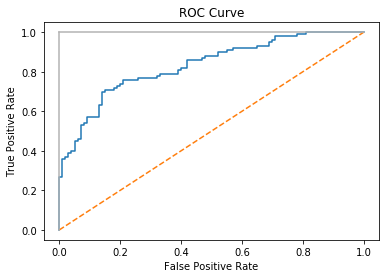

In [47]:
print('roc_auc_score: ', roc_auc_score(actual_values, preds_))
plot_roc('ROC Curve', false_positive_rate, true_positive_rate)

pr_auc_score:  0.8514282676635189


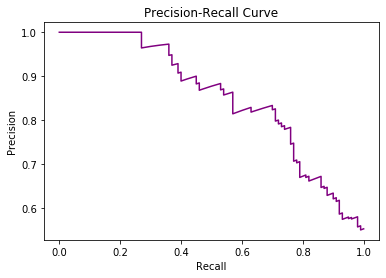

In [48]:
print('pr_auc_score: ', average_precision_score(actual_values, preds_))
plot_pr_curve(actual_values, preds_)

In [49]:
# compare_predictions_Adam(preds, preds_, actual_values, adam_test_1, df_adam_no_repeats_no_same_up_sampled)

In [50]:
# compare_predictions_Brenda(preds, preds_, actual_values, brenda_test_1, df_brenda_no_repeats)

In [51]:
lr.fit(X=train_X_2, y=train_y_2)
preds = lr.predict(X=test_X_2)
adam_y_test = preds[:100]
brenda_y_test = preds[100:]
actual_values = [0] * 100 + [1] * 100
predicted_values = list(preds[:100]) + list(preds[100:])
preds_ = lr.predict_proba(test_X_2)[:,1]
false_positive_rate, true_positive_rate, threshold = roc_curve(actual_values, preds_)
conf_matrix = confusion_matrix(actual_values, predicted_values)
conf_matrix

array([[79, 21],
       [25, 75]])

In [52]:
accuracy(conf_matrix)

0.77

In [53]:
precision(conf_matrix)

0.75

In [54]:
recall(conf_matrix)

0.78125

In [55]:
specificity(conf_matrix)

0.7596153846153846

In [56]:
f1(conf_matrix)

0.7653061224489796

roc_auc_score:  0.8786


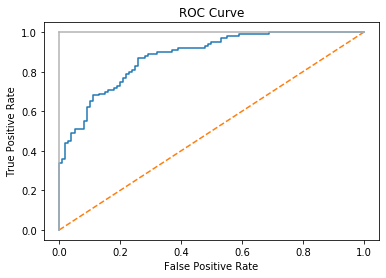

In [57]:
print('roc_auc_score: ', roc_auc_score(actual_values, preds_))
plot_roc('ROC Curve', false_positive_rate, true_positive_rate)

pr_auc_score:  0.8845625878171114


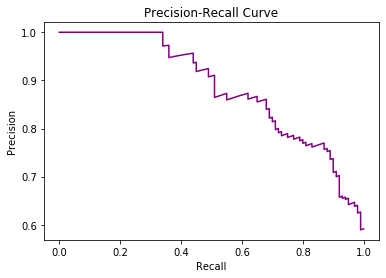

In [58]:
print('pr_auc_score: ', average_precision_score(actual_values, preds_))
plot_pr_curve(actual_values, preds_)

In [59]:
# compare_predictions_Adam(preds, preds_, actual_values, adam_test_2, df_adam_no_repeats_no_same_up_sampled)

In [60]:
# compare_predictions_Brenda(preds, preds_, actual_values, brenda_test_2, df_brenda_no_repeats)

In [61]:
lr.fit(X=train_X_3, y=train_y_3)
preds = lr.predict(X=test_X_3)
adam_y_test = preds[:100]
brenda_y_test = preds[100:]
actual_values = [0] * 100 + [1] * 100
predicted_values = list(preds[:100]) + list(preds[100:])
preds_ = lr.predict_proba(test_X_3)[:,1]
false_positive_rate, true_positive_rate, threshold = roc_curve(actual_values, preds_)
conf_matrix = confusion_matrix(actual_values, predicted_values)
conf_matrix

array([[74, 26],
       [27, 73]])

In [62]:
accuracy(conf_matrix)

0.735

In [63]:
precision(conf_matrix)

0.73

In [64]:
recall(conf_matrix)

0.7373737373737373

In [65]:
specificity(conf_matrix)

0.7326732673267327

In [66]:
f1(conf_matrix)

0.7336683417085427

roc_auc_score:  0.8123


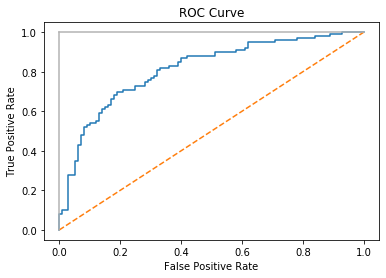

In [67]:
print('roc_auc_score: ', roc_auc_score(actual_values, preds_))
plot_roc('ROC Curve', false_positive_rate, true_positive_rate)

pr_auc_score:  0.8043326358513977


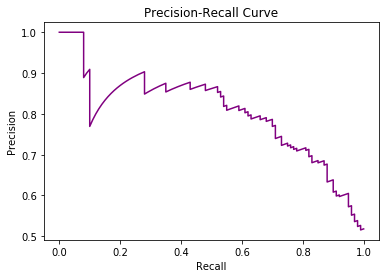

In [68]:
print('pr_auc_score: ', average_precision_score(actual_values, preds_))
plot_pr_curve(actual_values, preds_)

In [69]:
# compare_predictions_Adam(preds, preds_, actual_values, adam_test_3, df_adam_no_repeats_no_same_up_sampled)

In [70]:
# compare_predictions_Brenda(preds, preds_, actual_values, brenda_test_3, df_brenda_no_repeats)

In [71]:
lr.fit(X=train_X_4, y=train_y_4)
preds = lr.predict(X=test_X_4)
adam_y_test = preds[:100]
brenda_y_test = preds[100:]
actual_values = [0] * 100 + [1] * 100
predicted_values = list(preds[:100]) + list(preds[100:])
preds_ = lr.predict_proba(test_X_4)[:,1]
false_positive_rate, true_positive_rate, threshold = roc_curve(actual_values, preds_)
conf_matrix = confusion_matrix(actual_values, predicted_values)
conf_matrix

array([[76, 24],
       [16, 84]])

In [72]:
accuracy(conf_matrix)

0.8

In [73]:
precision(conf_matrix)

0.84

In [74]:
recall(conf_matrix)

0.7777777777777778

In [75]:
specificity(conf_matrix)

0.8260869565217391

In [76]:
f1(conf_matrix)

0.8076923076923077

roc_auc_score:  0.8486


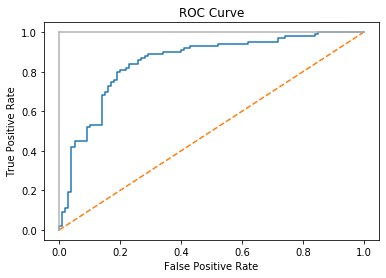

In [77]:
print('roc_auc_score: ', roc_auc_score(actual_values, preds_))
plot_roc('ROC Curve', false_positive_rate, true_positive_rate)

pr_auc_score:  0.8174128967633436


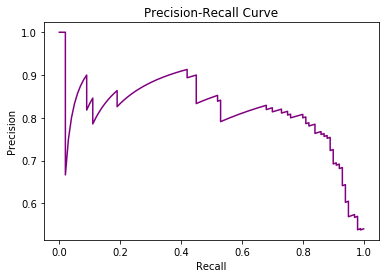

In [78]:
print('pr_auc_score: ', average_precision_score(actual_values, preds_))
plot_pr_curve(actual_values, preds_)

In [79]:
# compare_predictions_Adam(preds, preds_, actual_values, adam_test_4, df_adam_no_repeats_no_same_up_sampled)

In [80]:
# compare_predictions_Brenda(preds, preds_, actual_values, brenda_test_4, df_brenda_no_repeats)

In [81]:
lr.fit(X=train_X_5, y=train_y_5)
preds = lr.predict(X=test_X_5)
adam_y_test = preds[:100]
brenda_y_test = preds[100:]
actual_values = [0] * 100 + [1] * 100
predicted_values = list(preds[:100]) + list(preds[100:])
preds_ = lr.predict_proba(test_X_5)[:,1]
false_positive_rate, true_positive_rate, threshold = roc_curve(actual_values, preds_)
conf_matrix = confusion_matrix(actual_values, predicted_values)
conf_matrix

array([[74, 26],
       [20, 80]])

In [82]:
accuracy(conf_matrix)

0.77

In [83]:
precision(conf_matrix)

0.8

In [84]:
recall(conf_matrix)

0.7547169811320755

In [85]:
specificity(conf_matrix)

0.7872340425531915

In [86]:
f1(conf_matrix)

0.7766990291262137

roc_auc_score:  0.8553


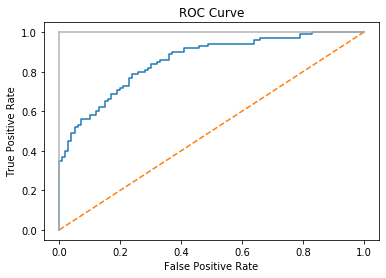

In [87]:
print('roc_auc_score: ', roc_auc_score(actual_values, preds_))
plot_roc('ROC Curve', false_positive_rate, true_positive_rate)

pr_auc_score:  0.8699215170678622


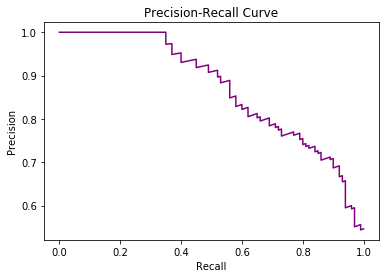

In [88]:
print('pr_auc_score: ', average_precision_score(actual_values, preds_))
plot_pr_curve(actual_values, preds_)

In [89]:
# compare_predictions_Adam(preds, preds_, actual_values, adam_test_5, df_adam_no_repeats_no_same_up_sampled)

In [90]:
# compare_predictions_Brenda(preds, preds_, actual_values, brenda_test_5, df_brenda_no_repeats)

### K-nearest neighbors

In [91]:
kn = KNeighborsClassifier()

In [92]:
# define search space
space = dict()

space['n_neighbors'] = [1,3,5,8,10,15,19,20,21,22,23,24,25,26,27,28,29,30,35,40,45,50]
space['weights'] = ['uniform', 'distance']
space['algorithm'] = ['ball_tree', 'kd_tree', 'brute']
# space['algorithm'] = ['auto', 'ball_tree', 'kd_tree', 'brute']

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=42)

search = GridSearchCV(kn, space, scoring='accuracy', cv=cv)

# execute search
result = search.fit(X=train_X_1, y=train_y_1)
# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Best Score: 0.7334152334152334
Best Hyperparameters: {'algorithm': 'ball_tree', 'n_neighbors': 23, 'weights': 'distance'}


/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [93]:
kn = KNeighborsClassifier(algorithm='ball_tree', n_neighbors=23, weights='distance')

In [94]:
kn.fit(X=train_X_1, y=train_y_1)
preds = kn.predict(X=test_X_1)
adam_y_test = preds[:100]
brenda_y_test = preds[100:]
actual_values = [0] * 100 + [1] * 100
predicted_values = list(preds[:100]) + list(preds[100:])
preds_ = kn.predict_proba(test_X_1)[:,1]
false_positive_rate, true_positive_rate, threshold = roc_curve(actual_values, preds_)
# in binary classification, 
# the count of true negatives is C_00,
# false negatives is C_10,
# true positives is  C_11, 
# and false positives is C_01.
conf_matrix = confusion_matrix(actual_values, predicted_values)
conf_matrix

array([[89, 11],
       [41, 59]])

In [95]:
accuracy(conf_matrix)

0.74

In [96]:
precision(conf_matrix)

0.59

In [97]:
recall(conf_matrix)

0.8428571428571429

In [98]:
specificity(conf_matrix)

0.6846153846153846

In [99]:
f1(conf_matrix)

0.6941176470588235

roc_auc_score:  0.8118


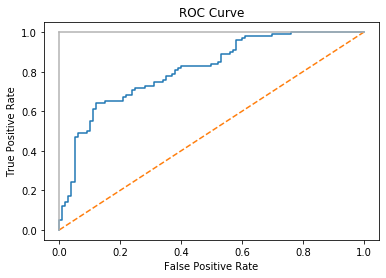

In [100]:
print('roc_auc_score: ', roc_auc_score(actual_values, preds_))
plot_roc('ROC Curve', false_positive_rate, true_positive_rate)

pr_auc_score:  0.8004063070706083


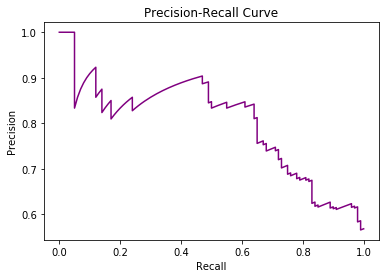

In [101]:
print('pr_auc_score: ', average_precision_score(actual_values, preds_))
plot_pr_curve(actual_values, preds_)

In [102]:
# compare_predictions_Adam(preds, preds_, actual_values, adam_test_1, df_adam_no_repeats_no_same_up_sampled)

In [103]:
# compare_predictions_Brenda(preds, preds_, actual_values, brenda_test_1, df_brenda_no_repeats)

In [104]:
kn.fit(X=train_X_2, y=train_y_2)
preds = kn.predict(X=test_X_2)
adam_y_test = preds[:100]
brenda_y_test = preds[100:]
actual_values = [0] * 100 + [1] * 100
predicted_values = list(preds[:100]) + list(preds[100:])
preds_ = kn.predict_proba(test_X_2)[:,1]
false_positive_rate, true_positive_rate, threshold = roc_curve(actual_values, preds_)
conf_matrix = confusion_matrix(actual_values, predicted_values)
conf_matrix

array([[86, 14],
       [44, 56]])

In [105]:
accuracy(conf_matrix)

0.71

In [106]:
precision(conf_matrix)

0.56

In [107]:
recall(conf_matrix)

0.8

In [108]:
specificity(conf_matrix)

0.6615384615384615

In [109]:
f1(conf_matrix)

0.6588235294117648

roc_auc_score:  0.8109999999999999


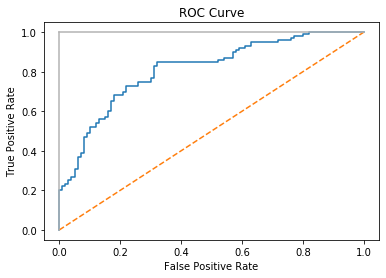

In [110]:
print('roc_auc_score: ', roc_auc_score(actual_values, preds_))
plot_roc('ROC Curve', false_positive_rate, true_positive_rate)

pr_auc_score:  0.8165163070285097


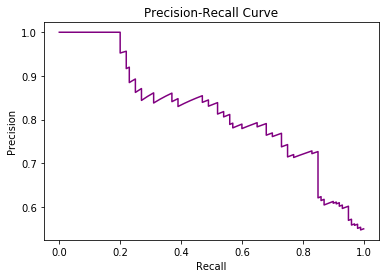

In [111]:
print('pr_auc_score: ', average_precision_score(actual_values, preds_))
plot_pr_curve(actual_values, preds_)

In [112]:
# compare_predictions_Adam(preds, preds_, actual_values, adam_test_2, df_adam_no_repeats_no_same_up_sampled)

In [113]:
# compare_predictions_Brenda(preds, preds_, actual_values, brenda_test_2, df_brenda_no_repeats)

In [114]:
kn.fit(X=train_X_3, y=train_y_3)
preds = kn.predict(X=test_X_3)
# preds
adam_y_test = preds[:100]
brenda_y_test = preds[100:]
actual_values = [0] * 100 + [1] * 100
predicted_values = list(preds[:100]) + list(preds[100:])
preds_ = kn.predict_proba(test_X_3)[:,1]
false_positive_rate, true_positive_rate, threshold = roc_curve(actual_values, preds_)
conf_matrix = confusion_matrix(actual_values, predicted_values)
conf_matrix

array([[79, 21],
       [44, 56]])

In [115]:
accuracy(conf_matrix)

0.675

In [116]:
precision(conf_matrix)

0.56

In [117]:
recall(conf_matrix)

0.7272727272727273

In [118]:
specificity(conf_matrix)

0.6422764227642277

In [119]:
f1(conf_matrix)

0.632768361581921

roc_auc_score:  0.7836


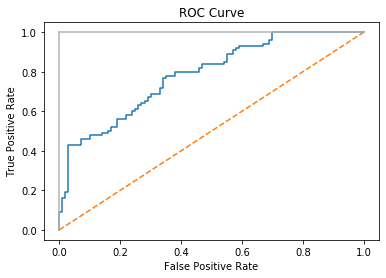

In [120]:
print('roc_auc_score: ', roc_auc_score(actual_values, preds_))
plot_roc('ROC Curve', false_positive_rate, true_positive_rate)

pr_auc_score:  0.7913595685241804


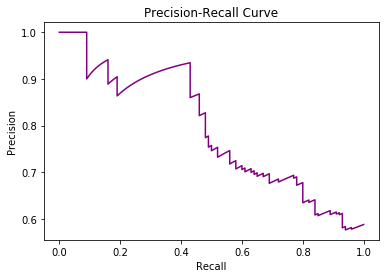

In [121]:
print('pr_auc_score: ', average_precision_score(actual_values, preds_))
plot_pr_curve(actual_values, preds_)

In [122]:
# compare_predictions_Adam(preds, preds_, actual_values, adam_test_3, df_adam_no_repeats_no_same_up_sampled)

In [123]:
# compare_predictions_Brenda(preds, preds_, actual_values, brenda_test_3, df_brenda_no_repeats)

In [124]:
kn.fit(X=train_X_4, y=train_y_4)
preds = kn.predict(X=test_X_4)
# preds
adam_y_test = preds[:100]
brenda_y_test = preds[100:]
actual_values = [0] * 100 + [1] * 100
predicted_values = list(preds[:100]) + list(preds[100:])
preds_ = kn.predict_proba(test_X_4)[:,1]
false_positive_rate, true_positive_rate, threshold = roc_curve(actual_values, preds_)
conf_matrix = confusion_matrix(actual_values, predicted_values)
conf_matrix

array([[82, 18],
       [35, 65]])

In [125]:
accuracy(conf_matrix)

0.735

In [126]:
precision(conf_matrix)

0.65

In [127]:
recall(conf_matrix)

0.7831325301204819

In [128]:
specificity(conf_matrix)

0.7008547008547008

In [129]:
f1(conf_matrix)

0.7103825136612022

roc_auc_score:  0.8268


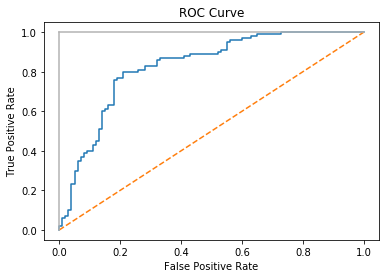

In [130]:
print('roc_auc_score: ', roc_auc_score(actual_values, preds_))
plot_roc('ROC Curve', false_positive_rate, true_positive_rate)

pr_auc_score:  0.7810602932852466


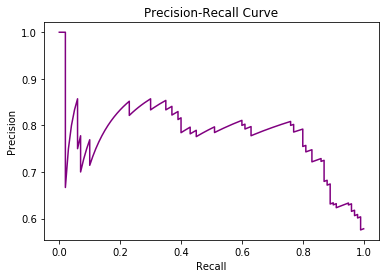

In [131]:
print('pr_auc_score: ', average_precision_score(actual_values, preds_))
plot_pr_curve(actual_values, preds_)

In [132]:
# compare_predictions_Adam(preds, preds_, actual_values, adam_test_4, df_adam_no_repeats_no_same_up_sampled)

In [133]:
# compare_predictions_Brenda(preds, preds_, actual_values, brenda_test_4, df_brenda_no_repeats)

In [134]:
kn.fit(X=train_X_5, y=train_y_5)
preds = kn.predict(X=test_X_5)
# preds
adam_y_test = preds[:100]
brenda_y_test = preds[100:]
actual_values = [0] * 100 + [1] * 100
predicted_values = list(preds[:100]) + list(preds[100:])
preds_ = kn.predict_proba(test_X_5)[:,1]
false_positive_rate, true_positive_rate, threshold = roc_curve(actual_values, preds_)
conf_matrix = confusion_matrix(actual_values, predicted_values)
conf_matrix

array([[88, 12],
       [44, 56]])

In [135]:
accuracy(conf_matrix)

0.72

In [136]:
precision(conf_matrix)

0.56

In [137]:
recall(conf_matrix)

0.8235294117647058

In [138]:
specificity(conf_matrix)

0.6666666666666666

In [139]:
f1(conf_matrix)

0.6666666666666666

roc_auc_score:  0.7974


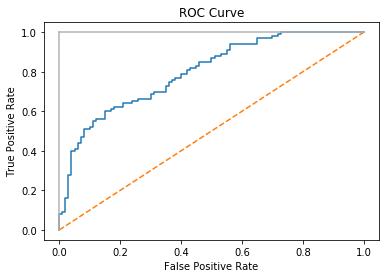

In [140]:
print('roc_auc_score: ', roc_auc_score(actual_values, preds_))
plot_roc('ROC Curve', false_positive_rate, true_positive_rate)

pr_auc_score:  0.7956575834197942


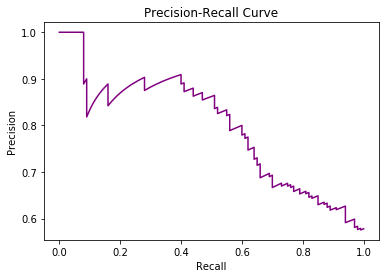

In [141]:
print('pr_auc_score: ', average_precision_score(actual_values, preds_))
plot_pr_curve(actual_values, preds_)

In [142]:
# compare_predictions_Adam(preds, preds_, actual_values, adam_test_5, df_adam_no_repeats_no_same_up_sampled)

In [143]:
# compare_predictions_Brenda(preds, preds_, actual_values, brenda_test_5, df_brenda_no_repeats)

### Linear Vector Machine

In [144]:
svc = SVC(random_state=42)

In [145]:
# define search space
space = dict()

space['C'] = [.1,1,3,5,7,9,10,11,12]
space['kernel'] = ['linear', 'poly', 'rbf', 'sigmoid']
space['degree'] = [1,2,3,4]
space['gamma'] = ['scale', 'auto']
space['probability'] = [True, False]
search = GridSearchCV(svc, space, scoring='accuracy')

# execute search
result = search.fit(X=train_X_1, y=train_y_1)
# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Best Score: 0.7751842751842751
Best Hyperparameters: {'C': 1, 'degree': 2, 'gamma': 'scale', 'kernel': 'poly', 'probability': True}


/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [146]:
svc = SVC(random_state=42,
          C=1,
          degree=2,
          gamma='scale',
          kernel='poly',
          probability=True)

In [147]:
svc.fit(X=train_X_1, y=train_y_1)
preds = svc.predict(X=test_X_1)
adam_y_test = preds[:100]
brenda_y_test = preds[100:]
actual_values = [0] * 100 + [1] * 100
predicted_values = list(preds[:100]) + list(preds[100:])
preds_ = svc.predict_proba(test_X_1)[:,1]
false_positive_rate, true_positive_rate, threshold = roc_curve(actual_values, preds_)
# in binary classification, 
# the count of true negatives is C_00,
# false negatives is C_10,
# true positives is  C_11, 
# and false positives is C_01.
conf_matrix = confusion_matrix(actual_values, predicted_values)
conf_matrix

array([[84, 16],
       [32, 68]])

In [148]:
accuracy(conf_matrix)

0.76

In [149]:
precision(conf_matrix)

0.68

In [150]:
recall(conf_matrix)

0.8095238095238095

In [151]:
specificity(conf_matrix)

0.7241379310344828

In [152]:
f1(conf_matrix)

0.7391304347826089

roc_auc_score:  0.8467


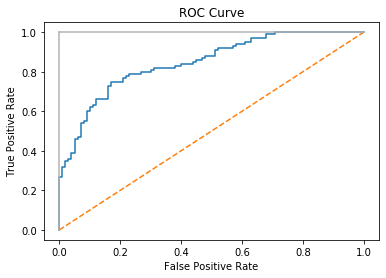

In [153]:
print('roc_auc_score: ', roc_auc_score(actual_values, preds_))
plot_roc('ROC Curve', false_positive_rate, true_positive_rate)

pr_auc_score:  0.8593297525933135


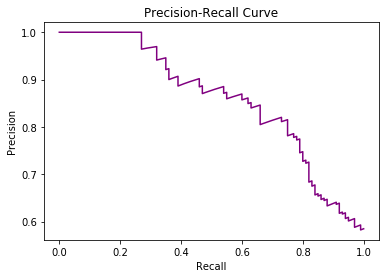

In [154]:
print('pr_auc_score: ', average_precision_score(actual_values, preds_))
plot_pr_curve(actual_values, preds_)

In [155]:
# compare_predictions_Adam(preds, preds_, actual_values, adam_test_1, df_adam_no_repeats_no_same_up_sampled)

In [156]:
# compare_predictions_Brenda(preds, preds_, actual_values, brenda_test_1, df_brenda_no_repeats)

In [157]:
svc.fit(X=train_X_2, y=train_y_2)
preds = svc.predict(X=test_X_2)
adam_y_test = preds[:100]
brenda_y_test = preds[100:]
actual_values = [0] * 100 + [1] * 100
predicted_values = list(preds[:100]) + list(preds[100:])
preds_ = svc.predict_proba(test_X_2)[:,1]
false_positive_rate, true_positive_rate, threshold = roc_curve(actual_values, preds_)
conf_matrix = confusion_matrix(actual_values, predicted_values)
conf_matrix

array([[86, 14],
       [26, 74]])

In [158]:
accuracy(conf_matrix)

0.8

In [159]:
precision(conf_matrix)

0.74

In [160]:
recall(conf_matrix)

0.8409090909090909

In [161]:
specificity(conf_matrix)

0.7678571428571429

In [162]:
f1(conf_matrix)

0.7872340425531915

roc_auc_score:  0.8946000000000001


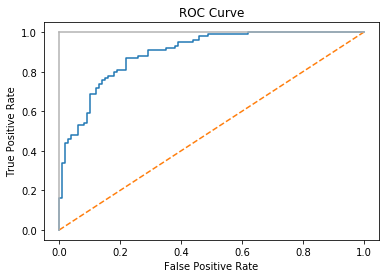

In [163]:
print('roc_auc_score: ', roc_auc_score(actual_values, preds_))
plot_roc('ROC Curve', false_positive_rate, true_positive_rate)

pr_auc_score:  0.8888952634136842


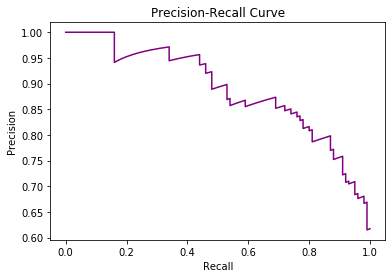

In [164]:
print('pr_auc_score: ', average_precision_score(actual_values, preds_))
plot_pr_curve(actual_values, preds_)

In [165]:
# compare_predictions_Adam(preds, preds_, actual_values, adam_test_2, df_adam_no_repeats_no_same_up_sampled)

In [166]:
# compare_predictions_Brenda(preds, preds_, actual_values, brenda_test_2, df_brenda_no_repeats)

In [167]:
svc.fit(X=train_X_3, y=train_y_3)
preds = svc.predict(X=test_X_3)
adam_y_test = preds[:100]
brenda_y_test = preds[100:]
actual_values = [0] * 100 + [1] * 100
predicted_values = list(preds[:100]) + list(preds[100:])
preds_ = svc.predict_proba(test_X_3)[:,1]
false_positive_rate, true_positive_rate, threshold = roc_curve(actual_values, preds_)
conf_matrix = confusion_matrix(actual_values, predicted_values)
conf_matrix

array([[78, 22],
       [27, 73]])

In [168]:
accuracy(conf_matrix)

0.755

In [169]:
precision(conf_matrix)

0.73

In [170]:
recall(conf_matrix)

0.7684210526315789

In [171]:
specificity(conf_matrix)

0.7428571428571429

In [172]:
f1(conf_matrix)

0.7487179487179486

roc_auc_score:  0.8214


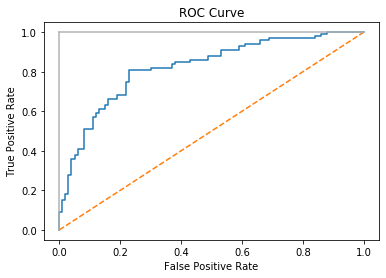

In [173]:
print('roc_auc_score: ', roc_auc_score(actual_values, preds_))
plot_roc('ROC Curve', false_positive_rate, true_positive_rate)

pr_auc_score:  0.8183256881933391


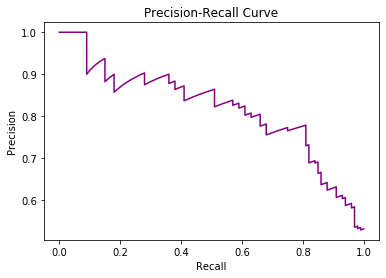

In [174]:
print('pr_auc_score: ', average_precision_score(actual_values, preds_))
plot_pr_curve(actual_values, preds_)

In [175]:
# compare_predictions_Adam(preds, preds_, actual_values, adam_test_3, df_adam_no_repeats_no_same_up_sampled)

In [176]:
# compare_predictions_Brenda(preds, preds_, actual_values, brenda_test_3, df_brenda_no_repeats)

In [177]:
svc.fit(X=train_X_4, y=train_y_4)
preds = svc.predict(X=test_X_4)
adam_y_test = preds[:100]
brenda_y_test = preds[100:]
actual_values = [0] * 100 + [1] * 100
predicted_values = list(preds[:100]) + list(preds[100:])
preds_ = svc.predict_proba(test_X_4)[:,1]
false_positive_rate, true_positive_rate, threshold = roc_curve(actual_values, preds_)
conf_matrix = confusion_matrix(actual_values, predicted_values)
conf_matrix

array([[80, 20],
       [19, 81]])

In [178]:
accuracy(conf_matrix)

0.805

In [179]:
precision(conf_matrix)

0.81

In [180]:
recall(conf_matrix)

0.801980198019802

In [181]:
specificity(conf_matrix)

0.8080808080808081

In [182]:
f1(conf_matrix)

0.8059701492537314

roc_auc_score:  0.8514999999999999


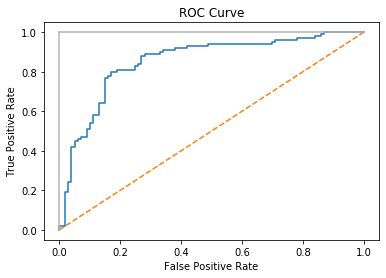

In [183]:
print('roc_auc_score: ', roc_auc_score(actual_values, preds_))
plot_roc('ROC Curve', false_positive_rate, true_positive_rate)

pr_auc_score:  0.8192342891032018


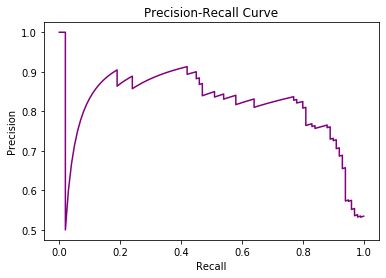

In [184]:
print('pr_auc_score: ', average_precision_score(actual_values, preds_))
plot_pr_curve(actual_values, preds_)

In [185]:
# compare_predictions_Adam(preds, preds_, actual_values, adam_test_4, df_adam_no_repeats_no_same_up_sampled)

In [186]:
# compare_predictions_Brenda(preds, preds_, actual_values, brenda_test_4, df_brenda_no_repeats)

In [187]:
svc.fit(X=train_X_5, y=train_y_5)
preds = svc.predict(X=test_X_5)
adam_y_test = preds[:100]
brenda_y_test = preds[100:]
actual_values = [0] * 100 + [1] * 100
predicted_values = list(preds[:100]) + list(preds[100:])
preds_ = svc.predict_proba(test_X_5)[:,1]
false_positive_rate, true_positive_rate, threshold = roc_curve(actual_values, preds_)
conf_matrix = confusion_matrix(actual_values, predicted_values)
conf_matrix

array([[75, 25],
       [19, 81]])

In [188]:
accuracy(conf_matrix)

0.78

In [189]:
precision(conf_matrix)

0.81

In [190]:
recall(conf_matrix)

0.7641509433962265

In [191]:
specificity(conf_matrix)

0.7978723404255319

In [192]:
f1(conf_matrix)

0.7864077669902914

roc_auc_score:  0.8524


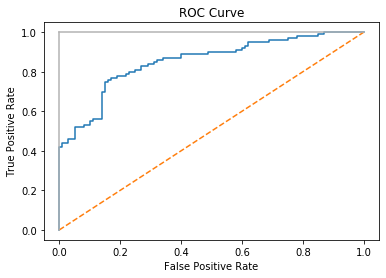

In [193]:
print('roc_auc_score: ', roc_auc_score(actual_values, preds_))
plot_roc('ROC Curve', false_positive_rate, true_positive_rate)

pr_auc_score:  0.8731752668573725


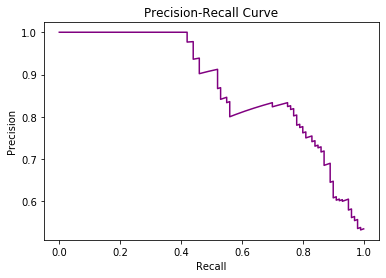

In [194]:
print('pr_auc_score: ', average_precision_score(actual_values, preds_))
plot_pr_curve(actual_values, preds_)

In [195]:
# compare_predictions_Adam(preds, preds_, actual_values, adam_test_5, df_adam_no_repeats_no_same_up_sampled)

In [196]:
# compare_predictions_Brenda(preds, preds_, actual_values, brenda_test_5, df_brenda_no_repeats)

### Decision tree

In [197]:
dt = DecisionTreeClassifier(random_state=42)

In [198]:
# define search space
space = dict()

space['criterion'] = ['gini', 'entropy']
space['splitter'] = ['best', 'random']
space['max_depth'] = [1,2,3,4,5,8,10, 12, 15]
space['min_samples_split'] = [2,5,10,15,20,25,30,35,40]
space['min_samples_leaf'] = [1,2,3,4,5,8,10,12,15]

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=42)

# define search
search = GridSearchCV(dt, space, scoring='accuracy', cv=cv)

# execute search
result = search.fit(X=train_X_1, y=train_y_1)
# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Best Score: 0.7641277641277642
Best Hyperparameters: {'criterion': 'gini', 'max_depth': 12, 'min_samples_leaf': 1, 'min_samples_split': 5, 'splitter': 'best'}


/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [199]:
dt = DecisionTreeClassifier(random_state=42,
                            criterion='gini',
                            max_depth=12, 
                            min_samples_leaf=1,
                            min_samples_split=5,
                            splitter='best')

In [200]:
dt.fit(X=train_X_1, y=train_y_1)
preds = dt.predict(X=test_X_1)
adam_y_test = preds[:100]
brenda_y_test = preds[100:]
actual_values = [0] * 100 + [1] * 100
predicted_values = list(preds[:100]) + list(preds[100:])
preds_ = dt.predict_proba(test_X_1)[:,1]
false_positive_rate, true_positive_rate, threshold = roc_curve(actual_values, preds_)
# in binary classification, 
# the count of true negatives is C_00,
# false negatives is C_10,
# true positives is  C_11, 
# and false positives is C_01.
conf_matrix = confusion_matrix(actual_values, predicted_values)
conf_matrix

array([[78, 22],
       [36, 64]])

In [201]:
accuracy(conf_matrix)

0.71

In [202]:
precision(conf_matrix)

0.64

In [203]:
recall(conf_matrix)

0.7441860465116279

In [204]:
specificity(conf_matrix)

0.6842105263157895

In [205]:
f1(conf_matrix)

0.6881720430107526

roc_auc_score:  0.72255


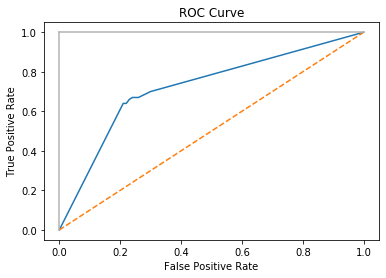

In [206]:
print('roc_auc_score: ', roc_auc_score(actual_values, preds_))
plot_roc('ROC Curve', false_positive_rate, true_positive_rate)

pr_auc_score:  0.6750764509779712


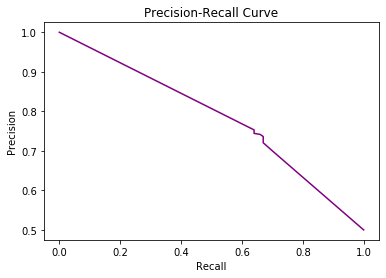

In [207]:
print('pr_auc_score: ', average_precision_score(actual_values, preds_))
plot_pr_curve(actual_values, preds_)

In [208]:
# compare_predictions_Adam(preds, preds_, actual_values, adam_test_1, df_adam_no_repeats_no_same_up_sampled)

In [209]:
# compare_predictions_Brenda(preds, preds_, actual_values, brenda_test_1, df_brenda_no_repeats)

In [210]:
dt.fit(X=train_X_2, y=train_y_2)
preds = dt.predict(X=test_X_2)
# preds
adam_y_test = preds[:100]
brenda_y_test = preds[100:]
actual_values = [0] * 100 + [1] * 100
predicted_values = list(preds[:100]) + list(preds[100:])
preds_ = dt.predict_proba(test_X_2)[:,1]
false_positive_rate, true_positive_rate, threshold = roc_curve(actual_values, preds_)
conf_matrix = confusion_matrix(actual_values, predicted_values)
conf_matrix

array([[78, 22],
       [31, 69]])

In [211]:
accuracy(conf_matrix)

0.735

In [212]:
precision(conf_matrix)

0.69

In [213]:
recall(conf_matrix)

0.7582417582417582

In [214]:
specificity(conf_matrix)

0.7155963302752294

In [215]:
f1(conf_matrix)

0.7225130890052356

roc_auc_score:  0.7359


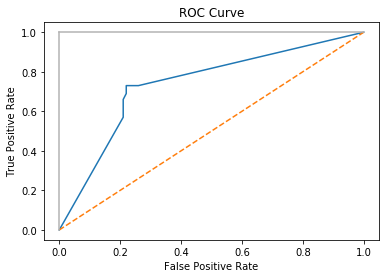

In [216]:
print('roc_auc_score: ', roc_auc_score(actual_values, preds_))
plot_roc('ROC Curve', false_positive_rate, true_positive_rate)

pr_auc_score:  0.67282694436233


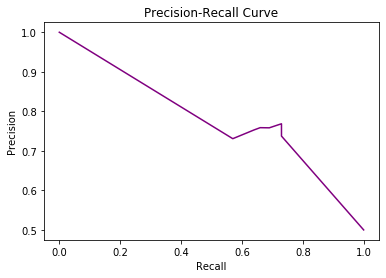

In [217]:
print('pr_auc_score: ', average_precision_score(actual_values, preds_))
plot_pr_curve(actual_values, preds_)

In [218]:
# compare_predictions_Adam(preds, preds_, actual_values, adam_test_2, df_adam_no_repeats_no_same_up_sampled)

In [219]:
# compare_predictions_Brenda(preds, preds_, actual_values, brenda_test_2, df_brenda_no_repeats)

In [220]:
dt.fit(X=train_X_3, y=train_y_3)
preds = dt.predict(X=test_X_3)
# preds
adam_y_test = preds[:100]
brenda_y_test = preds[100:]
actual_values = [0] * 100 + [1] * 100
predicted_values = list(preds[:100]) + list(preds[100:])
preds_ = dt.predict_proba(test_X_3)[:,1]
false_positive_rate, true_positive_rate, threshold = roc_curve(actual_values, preds_)
conf_matrix = confusion_matrix(actual_values, predicted_values)
conf_matrix

array([[68, 32],
       [30, 70]])

In [221]:
accuracy(conf_matrix)

0.69

In [222]:
precision(conf_matrix)

0.7

In [223]:
recall(conf_matrix)

0.6862745098039216

In [224]:
specificity(conf_matrix)

0.6938775510204082

In [225]:
f1(conf_matrix)

0.693069306930693

roc_auc_score:  0.70865


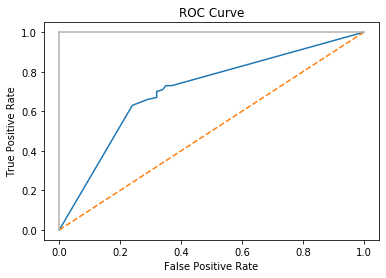

In [226]:
print('roc_auc_score: ', roc_auc_score(actual_values, preds_))
plot_roc('ROC Curve', false_positive_rate, true_positive_rate)

pr_auc_score:  0.6596225920590605


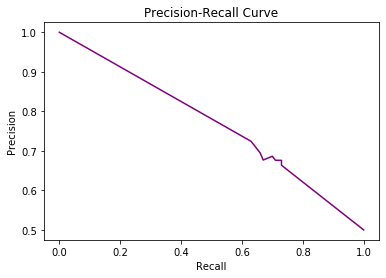

In [227]:
print('pr_auc_score: ', average_precision_score(actual_values, preds_))
plot_pr_curve(actual_values, preds_)

In [228]:
# compare_predictions_Adam(preds, preds_, actual_values, adam_test_3, df_adam_no_repeats_no_same_up_sampled)

In [229]:
# compare_predictions_Brenda(preds, preds_, actual_values, brenda_test_3, df_brenda_no_repeats)

In [230]:
dt.fit(X=train_X_4, y=train_y_4)
preds = dt.predict(X=test_X_4)
# preds
adam_y_test = preds[:100]
brenda_y_test = preds[100:]
actual_values = [0] * 100 + [1] * 100
predicted_values = list(preds[:100]) + list(preds[100:])
preds_ = dt.predict_proba(test_X_4)[:,1]
false_positive_rate, true_positive_rate, threshold = roc_curve(actual_values, preds_)
conf_matrix = confusion_matrix(actual_values, predicted_values)
conf_matrix

array([[74, 26],
       [30, 70]])

In [231]:
accuracy(conf_matrix)

0.72

In [232]:
precision(conf_matrix)

0.7

In [233]:
recall(conf_matrix)

0.7291666666666666

In [234]:
specificity(conf_matrix)

0.7115384615384616

In [235]:
f1(conf_matrix)

0.7142857142857142

roc_auc_score:  0.7418999999999999


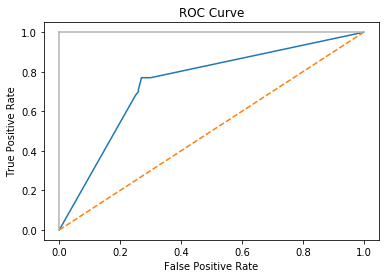

In [236]:
print('roc_auc_score: ', roc_auc_score(actual_values, preds_))
plot_roc('ROC Curve', false_positive_rate, true_positive_rate)

pr_auc_score:  0.6785302989605451


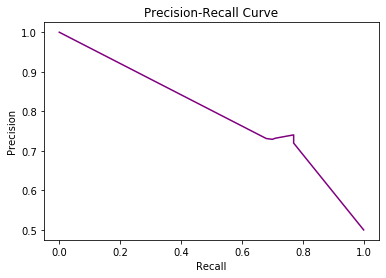

In [237]:
print('pr_auc_score: ', average_precision_score(actual_values, preds_))
plot_pr_curve(actual_values, preds_)

In [238]:
# compare_predictions_Adam(preds, preds_, actual_values, adam_test_4, df_adam_no_repeats_no_same_up_sampled)

In [239]:
# compare_predictions_Brenda(preds, preds_, actual_values, brenda_test_4, df_brenda_no_repeats)

In [240]:
dt.fit(X=train_X_5, y=train_y_5)
preds = dt.predict(X=test_X_5)
# preds
adam_y_test = preds[:100]
brenda_y_test = preds[100:]
actual_values = [0] * 100 + [1] * 100
predicted_values = list(preds[:100]) + list(preds[100:])
preds_ = dt.predict_proba(test_X_5)[:,1]
false_positive_rate, true_positive_rate, threshold = roc_curve(actual_values, preds_)
conf_matrix = confusion_matrix(actual_values, predicted_values)
conf_matrix

array([[81, 19],
       [26, 74]])

In [241]:
accuracy(conf_matrix)

0.775

In [242]:
precision(conf_matrix)

0.74

In [243]:
recall(conf_matrix)

0.7956989247311828

In [244]:
specificity(conf_matrix)

0.7570093457943925

In [245]:
f1(conf_matrix)

0.7668393782383419

roc_auc_score:  0.79505


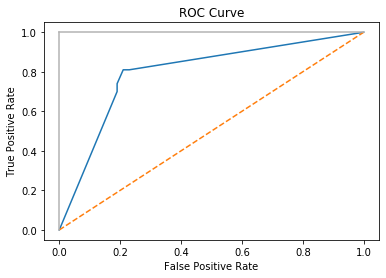

In [246]:
print('roc_auc_score: ', roc_auc_score(actual_values, preds_))
plot_roc('ROC Curve', false_positive_rate, true_positive_rate)

pr_auc_score:  0.7328881873657261


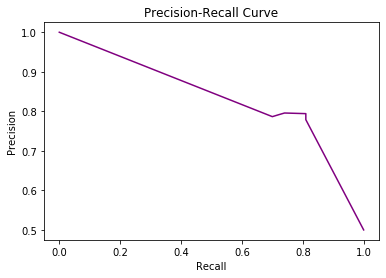

In [247]:
print('pr_auc_score: ', average_precision_score(actual_values, preds_))
plot_pr_curve(actual_values, preds_)

In [248]:
# compare_predictions_Adam(preds, preds_, actual_values, adam_test_5, df_adam_no_repeats_no_same_up_sampled)

In [249]:
# compare_predictions_Brenda(preds, preds_, actual_values, brenda_test_5, df_brenda_no_repeats)

## Random forest

In [250]:
rf = RandomForestClassifier(random_state=42)

In [251]:
# define search space
space = dict()

space['criterion'] = ['gini', 'entropy']
space['n_estimators'] = [1,10,100,300]
space['max_depth'] = [1,5,15,20,25,30]
space['max_features'] = ['sqrt', 'log2']
search = GridSearchCV(rf, space, scoring='accuracy')

# execute search
result = search.fit(X=train_X_1, y=train_y_1)
# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Best Score: 0.8071253071253072
Best Hyperparameters: {'criterion': 'gini', 'max_depth': 15, 'max_features': 'log2', 'n_estimators': 300}


In [252]:
rf = RandomForestClassifier(random_state=42,
                            criterion='gini',
                            max_depth=15,
                            max_features='log2',
                            n_estimators=300)

In [253]:
rf.fit(X=train_X_1, y=train_y_1)
preds = rf.predict(X=test_X_1)
adam_y_test = preds[:100]
brenda_y_test = preds[100:]
actual_values = [0] * 100 + [1] * 100
predicted_values = list(preds[:100]) + list(preds[100:])
preds_ = rf.predict_proba(test_X_1)[:,1]
false_positive_rate, true_positive_rate, threshold = roc_curve(actual_values, preds_)
# in binary classification, 
# the count of true negatives is C_00,
# false negatives is C_10,
# true positives is  C_11, 
# and false positives is C_01.
conf_matrix = confusion_matrix(actual_values, predicted_values)
conf_matrix

array([[84, 16],
       [28, 72]])

In [254]:
accuracy(conf_matrix)

0.78

In [255]:
precision(conf_matrix)

0.72

In [256]:
recall(conf_matrix)

0.8181818181818182

In [257]:
specificity(conf_matrix)

0.75

In [258]:
f1(conf_matrix)

0.7659574468085107

roc_auc_score:  0.8973


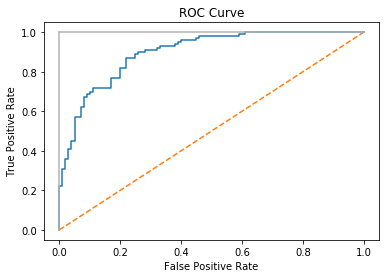

In [259]:
print('roc_auc_score: ', roc_auc_score(actual_values, preds_))
plot_roc('ROC Curve', false_positive_rate, true_positive_rate)

pr_auc_score:  0.8930818356300332


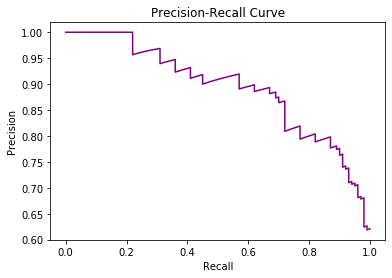

In [260]:
print('pr_auc_score: ', average_precision_score(actual_values, preds_))
plot_pr_curve(actual_values, preds_)

In [261]:
# compare_predictions_Adam(preds, preds_, actual_values, adam_test_1, df_adam_no_repeats_no_same_up_sampled)

In [262]:
# compare_predictions_Brenda(preds, preds_, actual_values, brenda_test_1, df_brenda_no_repeats)

In [263]:
rf.fit(X=train_X_2, y=train_y_2)
preds = rf.predict(X=test_X_2)
adam_y_test = preds[:100]
brenda_y_test = preds[100:]
actual_values = [0] * 100 + [1] * 100
predicted_values = list(preds[:100]) + list(preds[100:])
preds_ = rf.predict_proba(test_X_2)[:,1]
false_positive_rate, true_positive_rate, threshold = roc_curve(actual_values, preds_)
conf_matrix = confusion_matrix(actual_values, predicted_values)
conf_matrix

array([[79, 21],
       [17, 83]])

In [264]:
accuracy(conf_matrix)

0.81

In [265]:
precision(conf_matrix)

0.83

In [266]:
recall(conf_matrix)

0.7980769230769231

In [267]:
specificity(conf_matrix)

0.8229166666666666

In [268]:
f1(conf_matrix)

0.8137254901960785

roc_auc_score:  0.9085000000000001


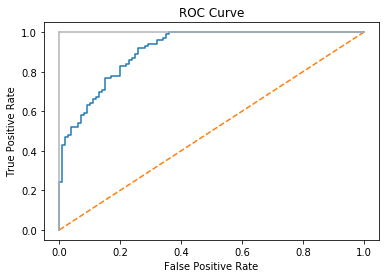

In [269]:
print('roc_auc_score: ', roc_auc_score(actual_values, preds_))
plot_roc('ROC Curve', false_positive_rate, true_positive_rate)

pr_auc_score:  0.9028634472790835


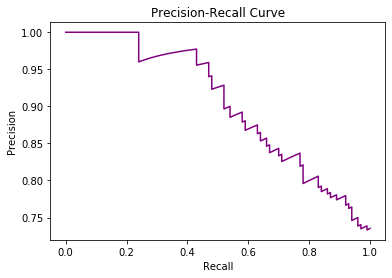

In [270]:
print('pr_auc_score: ', average_precision_score(actual_values, preds_))
plot_pr_curve(actual_values, preds_)

In [271]:
# compare_predictions_Adam(preds, preds_, actual_values, adam_test_2, df_adam_no_repeats_no_same_up_sampled)

In [272]:
# compare_predictions_Brenda(preds, preds_, actual_values, brenda_test_2, df_brenda_no_repeats)

In [273]:
rf.fit(X=train_X_3, y=train_y_3)
preds = rf.predict(X=test_X_3)
adam_y_test = preds[:100]
brenda_y_test = preds[100:]
actual_values = [0] * 100 + [1] * 100
predicted_values = list(preds[:100]) + list(preds[100:])
preds_ = rf.predict_proba(test_X_3)[:,1]
false_positive_rate, true_positive_rate, threshold = roc_curve(actual_values, preds_)
conf_matrix = confusion_matrix(actual_values, predicted_values)
conf_matrix

array([[75, 25],
       [15, 85]])

In [274]:
accuracy(conf_matrix)

0.8

In [275]:
precision(conf_matrix)

0.85

In [276]:
recall(conf_matrix)

0.7727272727272727

In [277]:
specificity(conf_matrix)

0.8333333333333334

In [278]:
f1(conf_matrix)

0.8095238095238095

roc_auc_score:  0.8834


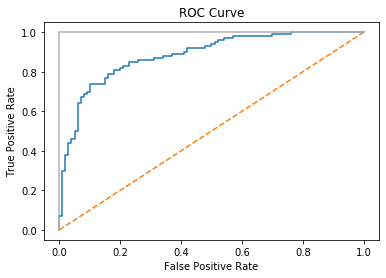

In [279]:
print('roc_auc_score: ', roc_auc_score(actual_values, preds_))
plot_roc('ROC Curve', false_positive_rate, true_positive_rate)

pr_auc_score:  0.8789219092553211


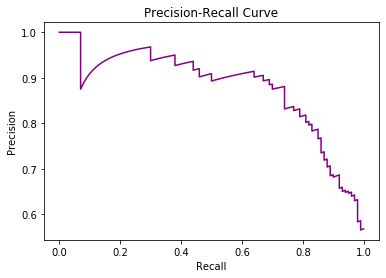

In [280]:
print('pr_auc_score: ', average_precision_score(actual_values, preds_))
plot_pr_curve(actual_values, preds_)

In [281]:
# compare_predictions_Adam(preds, preds_, actual_values, adam_test_3, df_adam_no_repeats_no_same_up_sampled)

In [282]:
# compare_predictions_Brenda(preds, preds_, actual_values, brenda_test_3, df_brenda_no_repeats)

In [283]:
rf.fit(X=train_X_4, y=train_y_4)
preds = rf.predict(X=test_X_4)
adam_y_test = preds[:100]
brenda_y_test = preds[100:]
actual_values = [0] * 100 + [1] * 100
predicted_values = list(preds[:100]) + list(preds[100:])
preds_ = rf.predict_proba(test_X_4)[:,1]
false_positive_rate, true_positive_rate, threshold = roc_curve(actual_values, preds_)
conf_matrix = confusion_matrix(actual_values, predicted_values)
conf_matrix

array([[76, 24],
       [12, 88]])

In [284]:
accuracy(conf_matrix)

0.82

In [285]:
precision(conf_matrix)

0.88

In [286]:
recall(conf_matrix)

0.7857142857142857

In [287]:
specificity(conf_matrix)

0.8636363636363636

In [288]:
f1(conf_matrix)

0.830188679245283

roc_auc_score:  0.8928


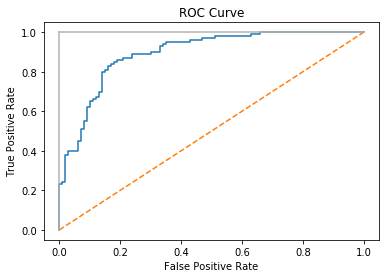

In [289]:
print('roc_auc_score: ', roc_auc_score(actual_values, preds_))
plot_roc('ROC Curve', false_positive_rate, true_positive_rate)

pr_auc_score:  0.8844315972532106


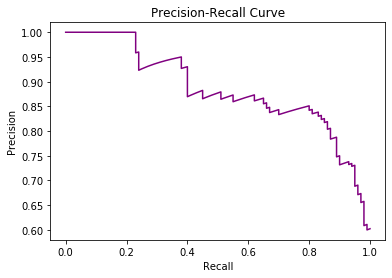

In [290]:
print('pr_auc_score: ', average_precision_score(actual_values, preds_))
plot_pr_curve(actual_values, preds_)

In [291]:
# compare_predictions_Adam(preds, preds_, actual_values, adam_test_4, df_adam_no_repeats_no_same_up_sampled)

In [292]:
# compare_predictions_Brenda(preds, preds_, actual_values, brenda_test_4, df_brenda_no_repeats)

In [293]:
rf.fit(X=train_X_5, y=train_y_5)
preds = rf.predict(X=test_X_5)
adam_y_test = preds[:100]
brenda_y_test = preds[100:]
actual_values = [0] * 100 + [1] * 100
predicted_values = list(preds[:100]) + list(preds[100:])
preds_ = rf.predict_proba(test_X_5)[:,1]
false_positive_rate, true_positive_rate, threshold = roc_curve(actual_values, preds_)
conf_matrix = confusion_matrix(actual_values, predicted_values)
conf_matrix

array([[74, 26],
       [14, 86]])

In [294]:
accuracy(conf_matrix)

0.8

In [295]:
precision(conf_matrix)

0.86

In [296]:
recall(conf_matrix)

0.7678571428571429

In [297]:
specificity(conf_matrix)

0.8409090909090909

In [298]:
f1(conf_matrix)

0.8113207547169812

roc_auc_score:  0.9037499999999999


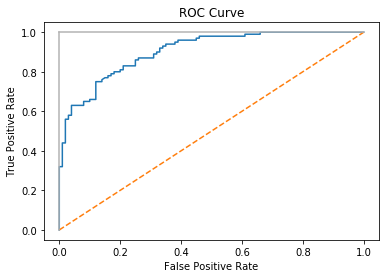

In [299]:
print('roc_auc_score: ', roc_auc_score(actual_values, preds_))
plot_roc('ROC Curve', false_positive_rate, true_positive_rate, save='../images/receiver_operating_characteristic.png')

pr_auc_score:  0.9096815365897483


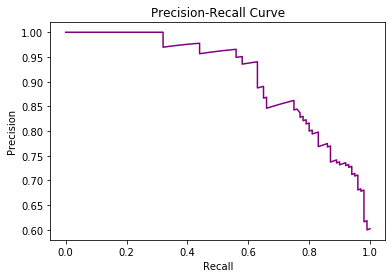

In [300]:
print('pr_auc_score: ', average_precision_score(actual_values, preds_))
plot_pr_curve(actual_values, preds_, save='../images/precision_recall.png')

#### Compare predictions including song information

- A correct prediction for Adam is 0, for Brenda is 1
- Songs are ordered in prediction probability, in other words, how confident the model was that the prediction was 1

In [301]:
Adam_predictions = compare_predictions_Adam(preds, preds_, actual_values, adam_test_5, df_adam_no_repeats_no_same_up_sampled)
Adam_predictions = Adam_predictions[['prediction', 'prediction_probability', 'name', 'artist', 'album']]

In [302]:
Brenda_predictions = compare_predictions_Brenda(preds, preds_, actual_values, brenda_test_5, df_brenda_no_repeats)
Brenda_predictions = Brenda_predictions[['prediction', 'prediction_probability', 'name', 'artist', 'album']]

In [303]:
# model incorrect
Adam_predictions.head()

,prediction,prediction_probability,name,artist,album
0,1,0.797778,Alive (Nightmare),Kid Cudi,Man On The Moon: The End Of Day
1,1,0.756458,Don't Forget to Dance,The Kinks,State of Confusion
2,1,0.677500,Breathe Deeper,Tame Impala,The Slow Rush
3,1,0.672620,Sick and Tired (ft. Machine Gun Kelly and Trav...,iann dior,I'm Gone
4,1,0.659630,Internet Killed The Rockstar,MOD SUN,Internet Killed The Rockstar


In [304]:
# model correct
Adam_predictions.tail()

,prediction,prediction_probability,name,artist,album
95,0,0.026667,All I Want,A Day To Remember,What Separates Me From You
96,0,0.021111,Up All Night,Hinder,Take It To The Limit
97,0,0.016667,Mindreader,A Day To Remember,Mindreader
98,0,0.016667,Mindreader,A Day To Remember,Mindreader
99,0,0.005000,Heavy Gloom,The Story So Far,The Story So Far


In [305]:
# model incorrect
Brenda_predictions.head()

,prediction,prediction_probability,name,artist,album
0,0,0.158333,Heart Attack,Wavves,V
1,0,0.206852,Good News,Mac Miller,Circles
2,0,0.301739,Photograph,Weezer,Weezer (Green Album)
3,0,0.311204,Taxi’s Here,Tame Impala,Currents B-Sides & Remixes
4,0,0.350000,Hypnotize,The White Stripes,Elephant


In [306]:
# model correct
Brenda_predictions.tail()

,prediction,prediction_probability,name,artist,album
95,1,0.930000,COPYCAT - Sofi Tukker Remix,Billie Eilish,COPYCAT (Sofi Tukker Remix)
96,1,0.931667,Something About Us,Daft Punk,Discovery
97,1,0.940000,Cellophane,King Gizzard & The Lizard Wizard,I'm In Your Mind Fuzz
98,1,0.950000,This Song Is Not About A Girl,Flume,Lockjaw
99,1,0.960000,Close Your Eyes (And Count To Fuck),Run The Jewels,Run The Jewels 2
